# Mean Shift
#### Basic Implementation
The following two functions find_peak and meanshift execute the basic mean shift algorithm.

In [120]:
import cv2
import math
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy.io import loadmat
from scipy import spatial
from sklearn.datasets import *
from IPython.core.display import clear_output
from util import 
%matplotlib inline
pylab.rcParams['figure.figsize'] = 16, 12

##### Load  and visualize sample data
The matrix is loaded into a numpy array of dimensions (2000, 3)

In [121]:
SAMPLE_DATA = loadmat("pts.mat")['data']
if False:  # Set to true to show the data
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, projection="3d")
    ax.scatter(SAMPLE_DATA[0], SAMPLE_DATA[1], SAMPLE_DATA[2])

##### Utility functions


In [122]:
cached_tree = None
def get_neighbours(data, point, r, *, use_cached_tree=False):
    """
    :data: The n-dimensional dataset containing p points
    :point: The data point for which the density peak will be computed
    :r: The distance at which points are considered neighbours
    :return: A list of points with a euclidian distance < r.
    """
    if len(data) == 0:
        return []
    if use_cached_tree:
        global cached_tree
        cached_tree = spatial.KDTree(data) if cached_tree is None else cached_tree
        tree = cached_tree
    else:
        tree = spatial.KDTree(data)
    ret = []
    return data[tree.query_ball_point(point, r)]

def get_neighbours_cdist(data, point, r):
    """
    :data: The n-dimensional dataset containing p points
    :point: The data point for which the density peak will be computed
    :r: The distance at which points are considered neighbours
    :return: A list of points with a euclidian distance < r.
    """
    ret = []
    if len(data) == 0 or len(data[0]) != 3 or point == None or r < 0:
        return []
    for i, d in enumerate(spatial.distance.cdist(np.array([point]), data)[0]):
        if d < r:
            ret.append(data[i])
    return np.array(ret)

In [126]:
def find_peak(data, point, r):
    """
    :data: The n-dimensional dataset containing p points
    :point: The data point for which the density peak will be computed
    :r: The search windows radius
    :return: The found peak.
    """
    neighbours = get_neighbours(data, point, r, use_cached_tree=True)
    peak = neighbours.mean(axis=0)
    return peak

def meanshift(data, r):
    """
    Calls find_peak for every point in data. 
    Similar peaks are merged after each call, if their distance is smaller than r/2.
    :data: The n-dimensional dataset containing p points
    :r: The search windows radius
    :return: A list of peaks and a list of points, annotated with the index of their peak.
    """
    peaks = []
    annotated = {
        "points": [],
        "peaks": []
    }
    data_transposed = data.transpose()
    for idx, point in log_progress(enumerate(data_transposed), 1, len(data_transposed)):
        # calculate peaks until convergence
        old_peak = None
        while True:
            point = point if old_peak is None else old_peak
            peak = find_peak(data_transposed, point, r)
            if old_peak is None:
                old_peak = peak
            else:
                # match peak to possible neighbours
                neighbours = get_neighbours_cdist(np.array(peaks), peak, r/2.)
                if len(neighbours) > 1:
                    peak = neighbours[0]
                    break
                elif spatial.distance.euclidean(peak, old_peak) <= 0.01:  # cdist cause len(neighbours)
                    peaks.append(peak)
                    break
                else:
                    old_peak = peak
        annotated["points"].append(point)
        annotated["peaks"].append(np.where(peaks==peak)[0][0])
    annotated["points"] = np.array(annotated["points"])
    annotated["points"] = annotated["points"].transpose()
    annotated["peaks"] = np.array(annotated["peaks"], dtype=np.float32)
    return peaks, annotated

##### Execute the meanshift function
Visualize the results

In [131]:
def visualize_meanshift(image, r):
    peaks, annotated = meanshift(image, r)
    p = annotated["points"]
    print("Found {} peaks in {} points !".format(len(peaks), p.shape[1],))
    fig = plt.figure(figsize=(20, 20))
    ax = fig.add_subplot(111, projection="3d")
    #ax.scatter(*peaks, color="red", s=10)
    ax.scatter(*p, color="blue", s=1)

/home/ric/.local/lib/python3.5/site-packages/ipykernel_launcher.py:28: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


Found 29 peaks in (3, 2000) points !


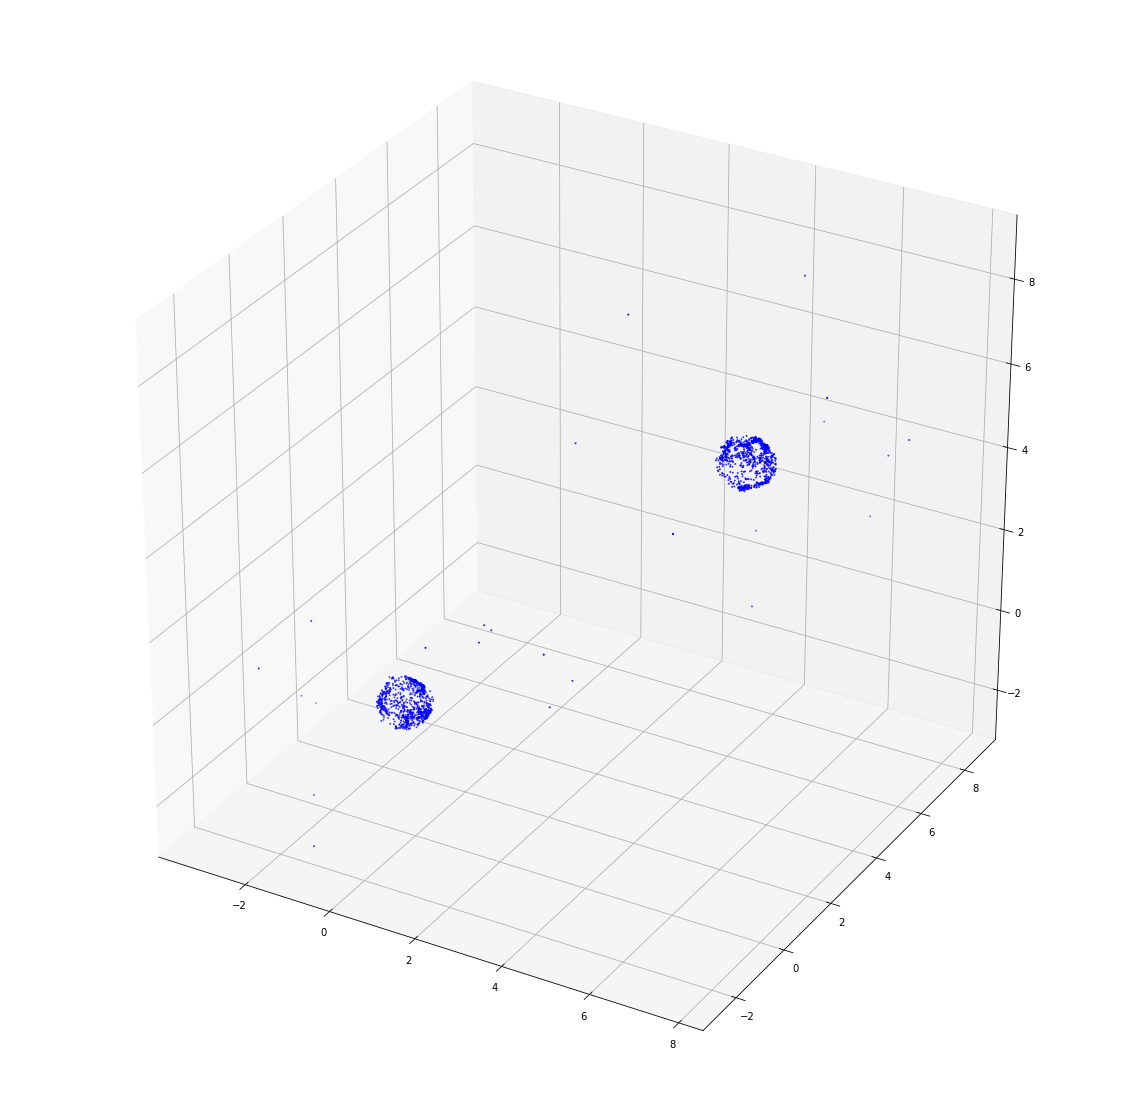

In [133]:
visualize_meanshift(SAMPLE_DATA, r=1)
visualize_meanshift(cv2.imread())